In [ ]:
import sys, os
ROOT = os.path.abspath(os.curdir)
PARENT = os.path.dirname(ROOT)

if PARENT not in sys.path:
    sys.path.insert(0, PARENT)

In [1]:

import numpy as np
import scipy as sp
import h5py

import src.SimData as sim_data
import src.Simulator as sim_system
import src.Optimizer as opt

In [2]:


###* Input files and function

reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                      'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                      'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

In [3]:


def func_optimization(params):
    
    A_D, B_D, E_D = params
    
    A = 0.01634
    B = 1.67e-4
    E = 19.75
    nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
    
    nu_D_mod = lambda T: 1e13 * (A_D + B_D * np.exp(E_D/(const_dict['R'] * T)))
    
    
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 31, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    
    {"id": None, "rate": None, "model_dict": {"nu_D": nu_D_mod}},
    ]
    
    return dict_mod_vec

loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)

exp_file = os.path.join(output_folder_path, exp_data_file)
sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [4]:

if __name__ == '__main__':
    optimizer = opt.Optimizer(sim, func_optimization, loss_function)

    global_bounds = [
                    (1e-4, 1e-1), (1e-6, 1e-3), (10.0, 25.0)
                    ]

    config = {
        "bounds": global_bounds,
        "de_maxiter": 3,
        "de_num_iterations": 1,
    }
    
    # best_local, best_local_loss = optimizer.hybrid_optimization_searchV2(config)

# differential_evolution step 50: f(x)= 0.041662857183863554


In [5]:
# print(best_local)
# print(best_local_loss)

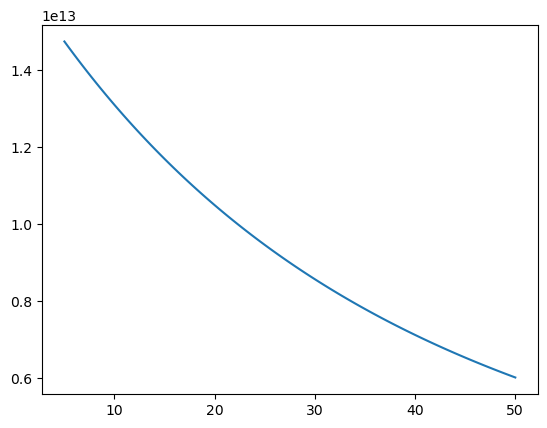

In [6]:

# 0.10488771444827552

A_D = 9.890e-02  
B_D = 9.999e-04  
E_D = 1.671e+01
nu_D_mod = lambda T: 1e13 * (A_D + B_D * np.exp(E_D/(const_dict['R'] * (T+273.15))))



import matplotlib.pyplot as plt 
Tspace = np.linspace(5, 50, 100)
plt.plot(Tspace, nu_D_mod(Tspace))


    


In [7]:
loss = optimizer.objective_function((0.0, 0.0, 5.0))
print(loss)

0.5119692641986203
